In [1]:
! brew install libomp
import ssl 
import math
import urllib.request
import json
import geopandas 
import pandas as pd
import numpy as np
import glob
import os
from collections import Counter
import matplotlib.pyplot as plt
from sodapy import Socrata
from functools import reduce
from IPython.display import display, HTML
import random
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import sklearn.metrics as metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from darts import TimeSeries
from darts.models import RNNModel, NBEATSModel, TransformerModel, NHiTSModel, BlockRNNModel
from darts.metrics import coefficient_of_variation, mae, mape, r2_score
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

To reinstall 16.0.6, run:
  brew reinstall libomp


/opt/homebrew/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /opt/homebrew/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /opt/homebrew/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


# Importing

## County Demographic Data 

In [2]:
def county_pipeline(folder_name, base_folder='gen1e_project'):
    """
    Imports county demographic data from a specified folder containing a set of .xls data objects. The base level
    folder containing all data must be located on the desktop

    Inputs
    -------
    folder_name: str
        name of the subfolder containing demographic data

    
    Outputs
    -------
    dem_df: pd.DataFrame
        aggregate dataframe containing demographic county data from 2016 to 2022
    """
    desktop = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop') 
    path = desktop + f"/{base_folder}" + f"/{folder_name}/"
    dem_files = glob.glob(os.path.join(path, "*.xlsx")) + glob.glob(os.path.join(path, "*.xls")) 

    dem_df = pd.concat((pd.read_excel(f, sheet_name='Ranked Measure Data', header=1).assign(file=os.path.basename(f).split()[0]) for f in dem_files), ignore_index=True)

    # deals with inconsistent column names across years through elementwise addition on the related columns
    dem_df['health'] = dem_df.loc[:,['% Fair or Poor Health', '% Fair/Poor']].fillna(0).sum(axis=1)
    dem_df['obesity'] = dem_df.loc[:,['% Adults with Obesity', '% Obese']].fillna(0).sum(axis=1)

    # drop irrelevent columns
    dem_df = dem_df[['Population', 'FIPS', 'health', '% Smokers', 'obesity', '% Excessive Drinking',
                                'Average Daily PM2.5','file']]

    dem_df = dem_df.dropna(subset = 'FIPS')
    dem_df['FIPS'] = dem_df['FIPS'].astype('int')

    dem_df = dem_df.rename(columns={'FIPS': "fips", "Population": "population", "% Smokers": "smokers", '% Excessive Drinking': "drinking", 'Average Daily PM2.5': "pollution", 'file': 'year'})

    # coerces FIPS codes to strings so that the state fips code can be extracted
    dem_df['fips'] = dem_df['fips'].astype("string")
    dem_df['fips'] = [f"0{i}" if len(str(i)) == 4 else str(i) for i in dem_df['fips']]
    dem_df['state_fips'] = dem_df['fips'].str[:2]

    dem_df = dem_df.sort_values(by=['year', 'fips'])

    dem_df['year'] = dem_df['year'].astype('string')

    return dem_df

base_df = county_pipeline("dem_data")

In [3]:
dem_df = base_df.copy(deep=True)

## CDC Wonder Data

In [4]:
def wonder_pipeline(identifier, base_folder='gen1e_project'):
    """
    Imports disease data (pneumonia, sepsis, hypertension) from specified txt files. The base level
    folder containing all data must be located on the desktop.


    Inputs
    -------
    identifier: str
        name of the identifier that distinguishes the subfolder from others (e.g. sep, hyp, pn)
    base_folder: str
        the name of the base folder within which all data for the project is located
    
    Outputs
    -------
    wonder_df: pd.DataFrame
        aggregate dataframe containing disease county data from 2016 to 2022
    """
    desktop = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop') 
    early_df = pd.read_csv(desktop + f"/{base_folder}" + f"/{identifier}_data/{identifier}-early.txt", sep="\t", on_bad_lines='warn')
    late_df = pd.read_csv(desktop + f"/{base_folder}" + f"/{identifier}_data/{identifier}-late.txt", sep="\t", on_bad_lines='warn')

    # preprocess data
    early_df = early_df.dropna(subset=['County Code'])
    early_df['Deaths'] = early_df['Deaths'].apply(pd.to_numeric, errors='coerce') # suppressed and missing data to NaN
    early_df = early_df.rename(columns={"Notes": "notes", "County": "county", "County Code": "fips", "Year": "year", "Year Code": "year_code", "Deaths": f"{identifier}_deaths", "Population": "population", "Crude Rate": "crude_rate"})

    late_df = late_df.dropna(subset=['Occurrence County Code'])
    late_df['Deaths'] = late_df['Deaths'].apply(pd.to_numeric, errors='coerce') # suppressed and missing data to NaN
    late_df = late_df.rename(columns={"Notes": "notes", "Occurrence County": "county", "Occurrence County Code": "fips", "Year": "year", "Year Code": "year_code", "Deaths": f"{identifier}_deaths", "Population": "population", "Crude Rate": "crude_rate"})

    wonder_df = pd.concat([early_df, late_df])

    wonder_df = wonder_df.drop(['notes', 'crude_rate'], axis=1)

    # standardises fips and year data for string conversion later
    wonder_df[['fips', 'year_code']] = wonder_df[['fips', 'year_code']].astype({'fips': 'int', 'year_code': 'int'})

    wonder_df['predictor'] = identifier

    return wonder_df

# sepsis (A40, A41)
sep_df = wonder_pipeline('sep')

# pneumonia (J12, J13, J14, J15, J16, J18)
pn_df = wonder_pipeline('pn')

# hypertension (I10, I11, I12, I13, I15)
hyp_df = wonder_pipeline('hyp')

In [5]:
sep_df = sep_df[['fips', 'year_code', 'sep_deaths']]
pn_df = pn_df[['fips', 'year_code', 'pn_deaths']]
hyp_df = hyp_df[['fips', 'year_code', 'hyp_deaths']]

# outer merge preserves as much information as possible so that we can interpolate missing data
disease_df = sep_df.merge(pn_df, on = ['fips', 'year_code'], how = 'outer').merge(hyp_df, on = ['fips', 'year_code'], how = 'outer')#.set_index('fips')
disease_df = disease_df.sort_values(by=['year_code', 'fips'])

# coerce fips into a standardised five digit string format
disease_df['fips'] = disease_df['fips'].astype("string")
disease_df['fips'] = [f"0{i}" if len(str(i)) == 4 else str(i) for i in disease_df['fips']]
disease_df = disease_df.reset_index().set_index('index')
disease_df = disease_df.rename(columns={'year_code': "year"})

disease_df['year'] = disease_df['year'].astype('string')

## RSP Data

In [6]:
def process_nis_data(foldername, identifier, base_folder="gen1e_project"):
    """
    Imports data from NIS dataset files (.xlsx). The base level folder containing all data must be located on the desktop.
    Infers relevant years from folder naming structure, because they're not included in the dataset by default. 

    Inputs
    -------
    folder_name: str
        the name of the ffolder containing rsp data
    identifier: str
        name of the identifier to label the discharges
    base_folder: str
        the name of the base folder within which all data for the project is located

    
    Outputs
    -------
    df: pd.DataFrame
        aggregate dataframe containing outcome from 2016 to 2020
    """
    desktop = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop') 
    path = desktop + f"/{base_folder}" + f"/rsp012/{foldername}/"
    nis_files = glob.glob(os.path.join(path, "*.xlsx"))

    df = pd.concat((pd.read_excel(f, sheet_name='Table Data').assign(New=os.path.basename(f))[2:] for f in nis_files), ignore_index=True)
    df = df.replace('*', np.nan)
    df['Number of Discharges'] = df['Number of Discharges'].apply(pd.to_numeric)

    df = df.rename(columns={'FIPS code': "fips", "Number of Discharges": f"{identifier}_discharges"})
    df['fips'] = df['fips'].astype(int).astype("string")
    df['fips'] = [f"0{i}" if len(str(i)) == 4 else str(i) for i in df['fips']]

    
    return df

In [7]:
rsp_2020 = process_nis_data('rsp012_2020', 'rsp_2020')
rsp_2020 = rsp_2020.sort_values('fips').drop_duplicates()
rsp_2020 = rsp_2020[['fips', 'rsp_2020_discharges']]

rsp_2019 = process_nis_data('RSP012 2019', 'rsp_2019')
rsp_2019 = rsp_2019.sort_values('fips').drop_duplicates()
rsp_2019 = rsp_2019[['fips', 'rsp_2019_discharges']]

rsp_2018 = process_nis_data('RSP012 2018', 'rsp_2018')
rsp_2018 = rsp_2018.sort_values('fips').drop_duplicates()
rsp_2018 = rsp_2018[['fips', 'rsp_2018_discharges']]

rsp_2017 = process_nis_data('RSP012 2017', 'rsp_2017')
rsp_2017 = rsp_2017.sort_values('fips').drop_duplicates()
rsp_2017 = rsp_2017[['fips', 'rsp_2017_discharges']]

rsp_2016 = process_nis_data('rsp012_2016', 'rsp_2016')
rsp_2016 = rsp_2016.sort_values('fips').drop_duplicates()
rsp_2016 = rsp_2016[['fips', 'rsp_2016_discharges']]

In [8]:
rsp_df = rsp_2016.merge(rsp_2017, on='fips', how='outer').merge(rsp_2018, on='fips', how='outer').merge(rsp_2019, on='fips', how='outer').merge(rsp_2020, on='fips', how='outer')

# converts year columns into separate rows so taht they're standardised with the rest of the dataset
rsp_df = rsp_df.melt(id_vars=['fips'], var_name='year', value_name="outcome")

# rename for specific years
rsp_map = {'rsp_2016_discharges': '2016', 'rsp_2017_discharges': '2017', 'rsp_2018_discharges': '2018', 'rsp_2019_discharges': '2019','rsp_2020_discharges': '2020'}
rsp_df['year'] = rsp_df['year'].apply(lambda x: rsp_map[x])
rsp_df = rsp_df.sort_values(by=['year', 'fips'])
rsp_df['year'] = rsp_df['year'].astype("string")

In [9]:
rsp_df

,fips,year,outcome
0,02013,2016,NaN
1,02016,2016,NaN
2,02020,2016,382.0
3,02050,2016,16.0
4,02060,2016,NaN
...,...,...,...
12217,56037,2020,36.0
12218,56039,2020,NaN
12219,56041,2020,25.0
12220,56043,2020,NaN


# Merging

In [10]:
print('Demographic Data:', len(dem_df), 'rows')
print('Disease Data:', len(disease_df), 'rows')
print('Outcome Data:', len(rsp_df), "rows")

Demographic Data: 22140 rows
Disease Data: 22019 rows
Outcome Data: 12290 rows


In [11]:
display(HTML(dem_df.head().to_html()))

display(HTML(disease_df.head().to_html()))

display(HTML(rsp_df.head().to_html()))


,population,fips,health,smokers,obesity,drinking,pollution,year,state_fips
9579,14581.0,01001,19.4,18.7,30.9,15.1,12.92,2016,01
9580,46166.0,01003,16.0,18.6,26.7,15.1,13.13,2016,01
9581,7265.0,01005,25.7,21.4,40.8,12.4,12.62,2016,01
9582,6156.0,01007,22.0,21.0,40.1,13.8,12.87,2016,01
9583,14293.0,01009,20.7,19.4,32.4,14.1,12.66,2016,01


,fips,year,sep_deaths,pn_deaths,hyp_deaths
index,,,,,
0,01001,2016,30.0,19.0,68.0
5,01003,2016,134.0,68.0,217.0
10,01005,2016,20.0,10.0,30.0
15,01007,2016,19.0,21.0,16.0
20,01009,2016,40.0,47.0,29.0


,fips,year,outcome
0,02013,2016,NaN
1,02016,2016,NaN
2,02020,2016,382.0
3,02050,2016,16.0
4,02060,2016,NaN


In [12]:
# checking data types and unique key length, where key is a composite index of fips code and year

spacing = 1
print('\033[1m' + "Demographic Data:" + '\033[0m')
print('Key Length:', len(list(zip(*map(dem_df.get, ['fips', 'year'])))))
print('Unique Key Length:', len(set(list(zip(*map(dem_df.get, ['fips', 'year']))))))
print(dem_df[['fips', 'year']].dtypes, "\n"*spacing)

print('\033[1m' + "Disease Data:" + '\033[0m')
print('Key Length:', len(list(zip(*map(disease_df.get, ['fips', 'year'])))))
print('Unique Key Length:', len(set(list(zip(*map(disease_df.get, ['fips', 'year']))))))
print(disease_df[['fips', 'year']].dtypes, '\n'*spacing)

print('\033[1m' + "Outcome Data:" + '\033[0m')
print('Key Length:', len(list(zip(*map(rsp_df.get, ['fips', 'year'])))))
print('Unique Key Length:', len(set(list(zip(*map(rsp_df.get, ['fips', 'year']))))))
print(rsp_df[['fips', 'year']].dtypes, "\n"*spacing)

Demographic Data:
Key Length: 22140
Unique Key Length: 22140
fips    object
year    string
dtype: object 

Disease Data:
Key Length: 22019
Unique Key Length: 22019
fips    object
year    string
dtype: object 

Outcome Data:
Key Length: 12290
Unique Key Length: 12125
fips    object
year    string
dtype: object 



In [13]:
# merge all duplicates together
dataframes = [dem_df, disease_df, rsp_df]
t_df = reduce(lambda left, right: pd.merge(left, right, on=['fips', 'year'], how='outer'), dataframes)

In [14]:
# examine duplicates
t_df[t_df.duplicated(keep=False)]

# duplicates are identical copies, so data is not lost by removing duplicates
t_df = t_df.drop_duplicates(subset=['year', 'fips'])

assert sum(t_df.duplicated()) == 0

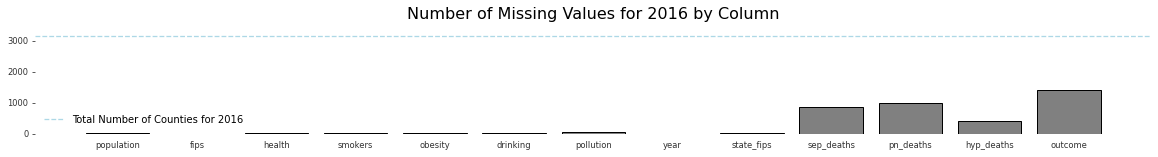

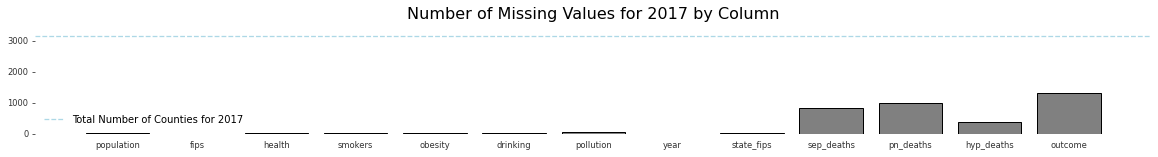

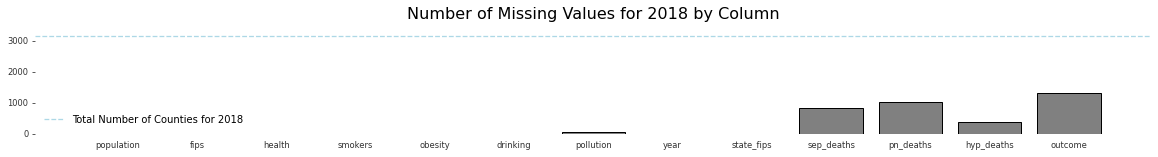

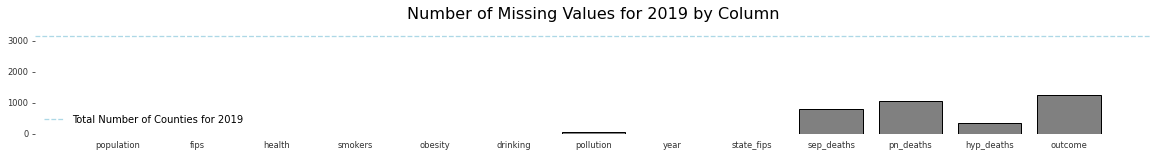

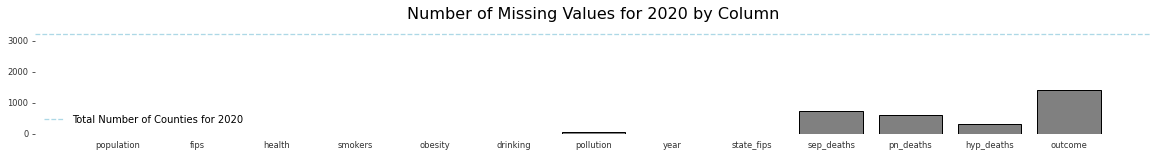

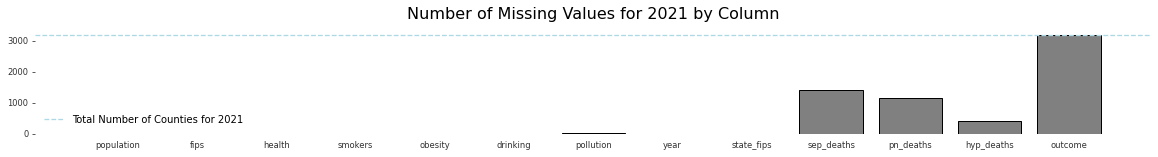

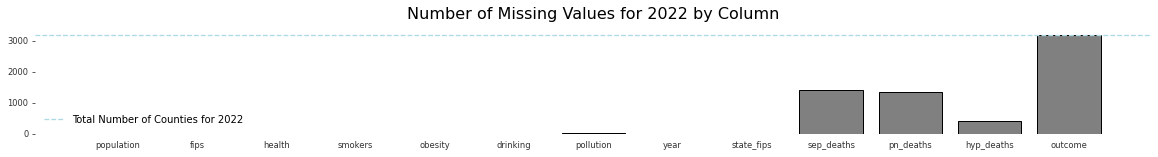

In [15]:
# visualises missing data by year to examine whether there are different distribvutions of missing data across time
# as expected, all values for the outcome are missing for 2021 and 2022 because we're trying to conduct regression on them using previous years

for year in sorted(set(t_df['year'])):
    plt.figure(figsize=(20, 2))
    plt.title(f"Number of Missing Values for {year} by Column", fontsize=16)
    plt.axhline(len(t_df[(t_df['year'] == year)]['fips']), color='lightblue', linestyle='--', label=f'Total Number of Counties for {year}')
    plt.legend()
    plt.bar(t_df.columns, [len(t_df[(t_df['year'] == year) & t_df[col].isna()]) for col in t_df.columns], ec='black', color='grey')
    plt.ylim(0, 3500)
    plt.grid(False)
    plt.show()

# Cleaning

In [16]:
df = t_df.copy(deep=True)

In [17]:
Counter(t_df['year'])

Counter({'2016': 3151,
         '2017': 3151,
         '2018': 3151,
         '2019': 3151,
         '2020': 3202,
         '2021': 3195,
         '2022': 3195})

## Data Type Coercion

In [18]:
df['fips'] = df['fips'].astype("string")
df['state_fips'] = df['state_fips'].astype("string")

print('\033[1m' + "Demographic Data:" + '\033[0m')
print(df.dtypes)

Demographic Data:
population    float64
fips           string
health        float64
smokers       float64
obesity       float64
drinking      float64
pollution     float64
year           string
state_fips     string
sep_deaths    float64
pn_deaths     float64
hyp_deaths    float64
outcome       float64
dtype: object


## Outcome Data

In [19]:
def interpolate_column(input_df, col):
    """
    Conducts interpolation on a column of the input dataframe, successively generalising its method as it encounters more 
    corrupted data.

    Initially interpolates by finding the nearest value from the same county across time. If only one other value is non-zero,
    it uses linear interpolation on the county data (i.e. fills all years with that value).

    For counties that have no data across the six years, interpolates by calculating the median value within the associated state and then
    adjusting the outcome by the relative size of the county compared to the size of the median county within the state.

    Inputs
    -------
    input_df: pd.DataFrame
        the dataframe for which we are interpolating data
    col: pd.Series
        the column in input_df for which we are interpolating data

    Outputs
    -------
    df[col]: pd.Series
        the adjusted column after interpolation has been performed
    """

    df = input_df.copy(deep=True)
    print(f"{df[col].isna().sum()} NA values identified for column {col}")

    # interpolate in cases where we have some county data

    # TODO (?): use spline interpolation instead for the first round of interpolation
    df.loc[:, col] = df.groupby('fips')[col].apply(lambda group: group.interpolate(method='nearest') if np.count_nonzero(np.isnan(group)) < (len(group) - 1) else group)
    df.loc[:, col] = df.groupby('fips')[col].apply(lambda group: group.interpolate(method='linear', limit_area='outside', limit_direction='both'))

    # interpolate from state data where there is no county data
    state_groups = df.groupby(['state_fips', 'year']).median()

    print(f"{state_groups[col].isna().sum()} NA values encountered for aggregate (US state) object")

    # the state groups object cannot have completely missing values, or it cannot be used for interpolation
    assert state_groups[col].isna().sum() == 0

    # calculate relative size of the county and the median county in the state
    relative_population = df[df[col].isna()]['population'] / list(state_groups.loc[list(zip(df[df[col].isna()]['state_fips'], df[df[col].isna()]['year'])), 'population'])

    df.loc[df[col].isna(), col] = list(state_groups.loc[list(zip(df[df[col].isna()]['state_fips'], df[df[col].isna()]['year'])), col]) * relative_population

    print(f"{df[col].isna().sum()} NA values remaining for column {col}")

    return df[col]

def interpolate_outcome_column(input_df, col='outcome'):
    """
    Conducts interpolation on the outcome column.

    Initially interpolates by finding the nearest value from the same county across time. If only one other value is non-zero,
    it uses linear interpolation on the county data (i.e. fills all years with that value).

    Differs from the method above in that it does not attempt to perform state level interpolation, and it does not interpolate any
    data from 2021 or 2022, where the outcome column is meant to only hold NaN values

    Inputs
    -------
    input_df: pd.DataFrame
        the dataframe for which we are interpolating data
    col: pd.Series (the outcoome column)
        the column in input_df for which we are interpolating data

    Outputs
    -------
    df[col]: pd.Series
        the adjusted column after interpolation has been performed
    """
    df = input_df.copy(deep=True)
    print(f"{df[col].isna().sum()} NA values identified for column {col}")

    # interpolate in cases where we have some county data, only on data not in 2021 and 2022
    df.loc[~df['year'].isin(['2021', '2022']), col] = df[~df['year'].isin(['2021', '2022'])].groupby('fips')[col].apply(lambda group: group.interpolate(method='nearest') if np.count_nonzero(np.isnan(group)) < (len(group) - 1) else group)
    df.loc[~df['year'].isin(['2021', '2022']), col] = df[~df['year'].isin(['2021', '2022'])].groupby('fips')[col].apply(lambda group: group.interpolate(method='linear', limit_area='outside', limit_direction='both'))

    # remove interpolated values from 2021 and 2022 
    df.loc[df['year'].isin(['2021', '2022']), col] = np.nan

    return df[col]
    


In [20]:
print('\033[1m' + "Before" + '\033[0m')
print('Total NA:', df['outcome'].isna().sum())
print('2021-22 NA', df.loc[df['year'].isin(['2021', '2022']), 'outcome'].isna().sum(), '\n')

# assert that before interpolation all data from 2021 and 2022 is NaN
assert len(df.loc[df['year'].isin(['2021','2022']), 'outcome']) == df.loc[df['year'].isin(['2021','2022']), 'outcome'].isna().sum()

df['outcome'] = interpolate_outcome_column(df, 'outcome')

print('\n', '\033[1m' + "After" + '\033[0m')
print('Total NA:', df['outcome'].isna().sum())
print('2021-2022 NA:', df.loc[df['year'].isin(['2021', '2022']), 'outcome'].isna().sum(), "\n")

# assert that afteri interpolation all data from 2021 and 2022 is NaN
assert len(df.loc[df['year'].isin(['2021','2022']), 'outcome']) == df.loc[df['year'].isin(['2021','2022']), 'outcome'].isna().sum()


Before
Total NA: 13025
2021-22 NA 6390 

13025 NA values identified for column outcome

 After
Total NA: 11966
2021-2022 NA: 6390 



In [21]:
print(len(df))
# remove all rows for which we have no outcome data (except for 2021 and 2022, for which we're trying to estimate outcome data)
df = df[df['outcome'].notna() | (df['year'].isin(['2021', '2022']))]
print(len(df))

22196
16620


In [22]:
# check for fips codes that represent states
state_df= df[df['fips'].str.endswith('000')]
display(state_df)

# drop rows that contain the partial string "000" (states)
df = df[~df['fips'].str.endswith('000')]
test_df = df[df['fips'].str.endswith('000')]
display(test_df)

,population,fips,health,smokers,obesity,drinking,pollution,year,state_fips,sep_deaths,pn_deaths,hyp_deaths,outcome
15919,3320877.0,01000,21.375809,19.989831,36.1,14.891378,9.20,2021,01,NaN,NaN,NaN,NaN
15987,480586.0,02000,15.565963,18.545983,31.9,17.610883,6.45,2021,02,NaN,NaN,NaN,NaN
16017,4732532.0,04000,18.623230,14.489278,27.9,18.126879,6.30,2021,04,NaN,NaN,NaN,NaN
16033,2011639.0,05000,23.271792,23.708256,35.0,17.253908,9.10,2021,05,NaN,NaN,NaN,NaN
16109,26471543.0,06000,17.613570,11.474007,24.3,18.126983,8.10,2021,06,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21978,5831949.0,51000,16.097187,14.159329,31.8,17.301860,7.30,2022,51,NaN,NaN,NaN,NaN
22112,5199771.0,53000,15.652624,12.750776,28.2,16.482785,8.10,2022,53,NaN,NaN,NaN,NaN
22152,1283869.0,54000,24.338804,26.136435,39.7,15.176299,7.60,2022,54,NaN,NaN,NaN,NaN
22208,3982118.0,55000,15.037194,16.197539,34.3,25.203839,7.50,2022,55,NaN,NaN,NaN,NaN


,population,fips,health,smokers,obesity,drinking,pollution,year,state_fips,sep_deaths,pn_deaths,hyp_deaths,outcome


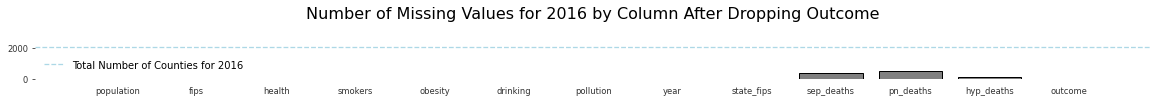

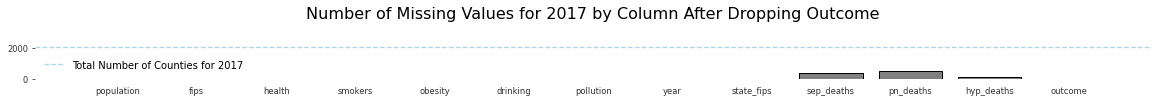

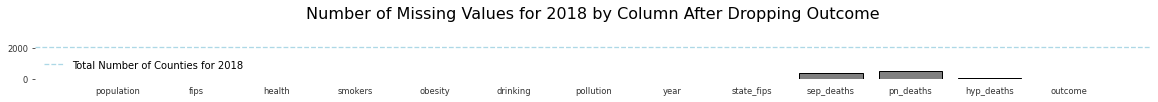

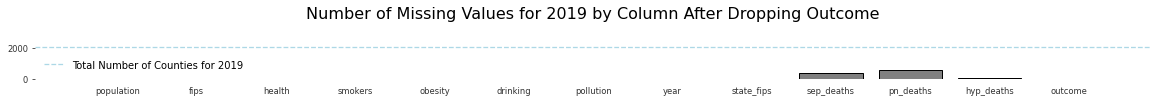

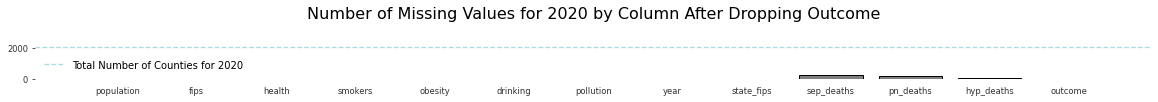

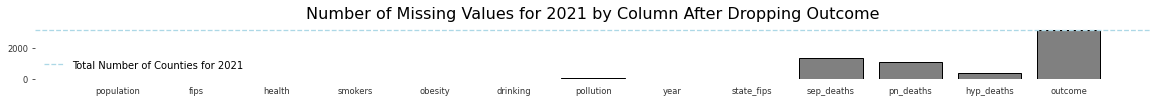

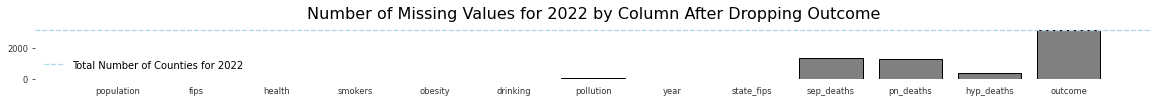

In [23]:
for year in sorted(set(df['year'])):
    plt.figure(figsize=(20, 1))
    plt.title(f"Number of Missing Values for {year} by Column After Dropping Outcome", fontsize=16)
    plt.axhline(len(df[(df['year'] == year)]['fips']), color='lightblue', linestyle='--', label=f'Total Number of Counties for {year}')
    plt.legend()
    plt.bar(df.columns, [len(df[(df['year'] == year) & df[col].isna()]) for col in df.columns], ec='black', color='grey')
    plt.ylim(0, 3500)
    plt.grid(False)
    plt.show()

In [24]:
df.isna().sum()

population       8
fips             0
health           8
smokers          8
obesity          8
drinking         8
pollution      145
year             0
state_fips       8
sep_deaths    4435
pn_deaths     4622
hyp_deaths    1085
outcome       6288
dtype: int64

## Demographic Data

In [25]:
df = df.dropna(subset='population')

In [26]:
dem_cols = ['health', 'smokers', 'obesity', 'drinking', 'pollution']

# interpolate all demographic columns with NA values
for col in dem_cols:
    if df[col].isna().sum() > 0:
        df[col] = interpolate_column(df, col)

print('\033[1m' + "After" + '\033[0m')
print(df.isna().sum())

137 NA values identified for column pollution
0 NA values encountered for aggregate (US state) object
0 NA values remaining for column pollution
After
population       0
fips             0
health           0
smokers          0
obesity          0
drinking         0
pollution        0
year             0
state_fips       0
sep_deaths    4428
pn_deaths     4614
hyp_deaths    1078
outcome       6284
dtype: int64


## Disease Data

In [27]:
disease_cols = ['sep_deaths', 'pn_deaths', 'hyp_deaths']

print('\033[1m' + "Before" + '\033[0m')
print(df.isna().sum(), "\n"*2)

# interpolate all disease columns for which there are NaN values
for col in disease_cols:
    if df[col].isna().sum() > 0:
        df[col] = interpolate_column(df, col)

print("\n", '\033[1m' + "After" + '\033[0m')
print(df.isna().sum())

Before
population       0
fips             0
health           0
smokers          0
obesity          0
drinking         0
pollution        0
year             0
state_fips       0
sep_deaths    4428
pn_deaths     4614
hyp_deaths    1078
outcome       6284
dtype: int64 


4428 NA values identified for column sep_deaths
0 NA values encountered for aggregate (US state) object
0 NA values remaining for column sep_deaths
4614 NA values identified for column pn_deaths
0 NA values encountered for aggregate (US state) object
0 NA values remaining for column pn_deaths
1078 NA values identified for column hyp_deaths
0 NA values encountered for aggregate (US state) object
0 NA values remaining for column hyp_deaths

 After
population       0
fips             0
health           0
smokers          0
obesity          0
drinking         0
pollution        0
year             0
state_fips       0
sep_deaths       0
pn_deaths        0
hyp_deaths       0
outcome       6284
dtype: int64


## Visualisation & Outliers

In [28]:
o_df = df.copy(deep=True)

In [29]:
corr = o_df.corr()
corr.style.background_gradient(cmap='Blues')


,population,health,smokers,obesity,drinking,pollution,sep_deaths,pn_deaths,hyp_deaths,outcome
population,1.000000,-0.060414,-0.192378,-0.184197,0.089358,0.062769,0.912176,0.890921,0.908886,0.932003
health,-0.060414,1.000000,0.722691,0.516444,-0.581885,0.009007,-0.054741,-0.036203,-0.064387,-0.076233
smokers,-0.192378,0.722691,1.000000,0.582910,-0.349292,0.008677,-0.198155,-0.158300,-0.206734,-0.172359
obesity,-0.184197,0.516444,0.582910,1.000000,-0.263124,0.052941,-0.193348,-0.159356,-0.196281,-0.217381
drinking,0.089358,-0.581885,-0.349292,-0.263124,1.000000,-0.279052,0.051252,0.053702,0.065757,0.108391
pollution,0.062769,0.009007,0.008677,0.052941,-0.279052,1.000000,0.114485,0.075898,0.099601,0.099786
sep_deaths,0.912176,-0.054741,-0.198155,-0.193348,0.051252,0.114485,1.000000,0.924356,0.956135,0.929960
pn_deaths,0.890921,-0.036203,-0.158300,-0.159356,0.053702,0.075898,0.924356,1.000000,0.918433,0.796887
hyp_deaths,0.908886,-0.064387,-0.206734,-0.196281,0.065757,0.099601,0.956135,0.918433,1.000000,0.915920
outcome,0.932003,-0.076233,-0.172359,-0.217381,0.108391,0.099786,0.929960,0.796887,0.915920,1.000000


In [30]:
o_df.describe()

,population,health,smokers,obesity,drinking,pollution,sep_deaths,pn_deaths,hyp_deaths,outcome
count,1.651000e+04,16510.000000,16510.000000,16510.000000,16510.000000,16510.000000,16510.000000,16510.000000,16510.000000,10226.000000
mean,4.704996e+04,18.820486,19.098643,32.912447,17.816060,9.023819,83.163216,81.398276,209.375783,183.399374
std,1.650398e+05,5.086485,4.119450,5.184371,3.592963,2.177289,242.268082,280.473196,593.804156,464.719380
min,6.200000e+01,7.200000,5.908719,10.700000,6.453001,0.002257,0.000000,0.000000,0.000000,11.000000
25%,4.411250e+03,14.880412,16.100000,29.700000,15.211429,7.700000,12.000000,12.000000,28.000000,27.000000
50%,1.045850e+04,18.215512,18.700000,33.100000,17.860349,9.100000,22.133209,22.000000,62.000000,60.500000
75%,3.049900e+04,22.100000,21.682970,36.400000,20.180484,10.210000,61.000000,56.840835,163.750000,158.000000
max,6.909179e+06,44.800000,44.571936,58.900000,31.013699,62.294833,8491.000000,13449.000000,18623.000000,10869.000000


In [31]:
### Sanity check: makes sense -- larger counties are responsible for the maximum deaths for each condition/disease
top_df = o_df[o_df['sep_deaths'] > o_df['sep_deaths'].quantile(.999)]
top_df = top_df[['population', 'fips', 'sep_deaths', 'hyp_deaths', 'pn_deaths', 'outcome']]
top_df.sort_values(by=['population'], ascending=False)

,population,fips,sep_deaths,hyp_deaths,pn_deaths,outcome
19321,6909179.0,06037,7253.0,16272.0,7403.0,NaN
16128,6886895.0,06037,8491.0,18223.0,13449.0,NaN
16543,3587576.0,17031,3030.0,8862.0,4514.0,NaN
19736,3584933.0,17031,3266.0,7641.0,3422.0,NaN
12902,2997389.0,06037,7688.0,18623.0,11486.0,7726.0
21779,2995908.0,48201,3555.0,7558.0,2771.0,NaN
9722,2991750.0,06037,5601.0,13998.0,4811.0,10484.0
6547,2965659.0,06037,5753.0,13381.0,5196.0,10454.0
18586,2963957.0,48201,4709.0,8286.0,6090.0,NaN
3372,2960843.0,06037,5608.0,13099.0,5050.0,10869.0


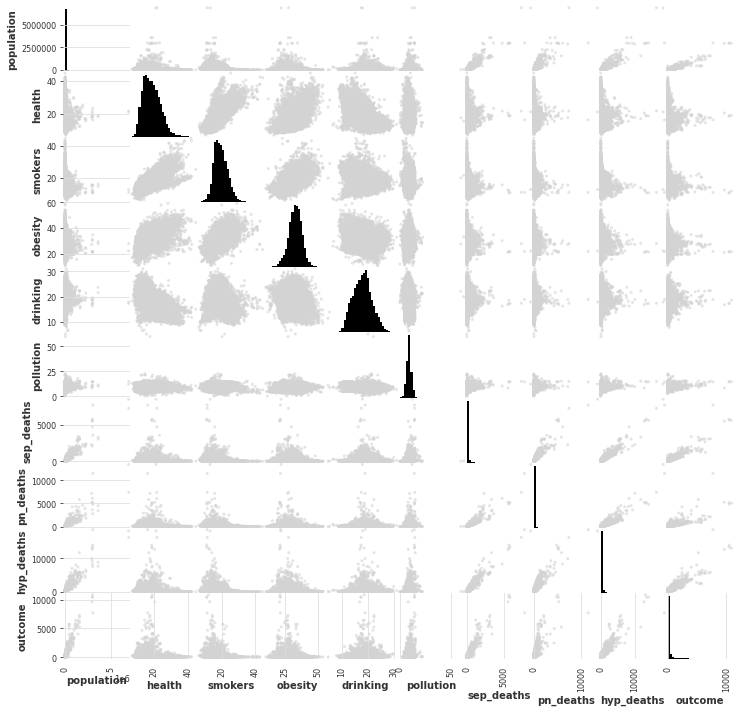

In [32]:
pd.plotting.scatter_matrix(o_df, hist_kwds={'bins':30}, alpha=0.6, figsize=(12,12), color='lightgrey')
plt.show()

# Regression

In [33]:
m_df = o_df.copy(deep=True)

In [34]:
def standardise_df(input_df, grouped=False, return_scaler=False):
    """
    Standardises all numerical columns of the input dataframe so that they have a mean of zero
    and a variance of 1. Necessary for ridge and lasso regression.

    Inputs
    ------
    input_df: pd.DataFrame() 
        the dataframe to be standardised
    grouped: bool
        whether the dataframe was generated through a groupby operation, which removes non-numerical columns
    return_scaler: bool
        whether the function should return the scaler object that was used to standardise the dataframe

    Outputs
    -------
    stand_df: pd.DataFrame()
        the standardised version of the dataframe
    standardised_scaler: sklearn.preprocessing.StandardScaler()
        the scaler used to perform standardisation
    """
    df = input_df.copy(deep=True)
    float_df = df.select_dtypes('float')
    other_df = df.select_dtypes(exclude='float')

    standardised_scaler = StandardScaler()

    stand_df = pd.DataFrame(standardised_scaler.fit_transform(float_df), columns=float_df.columns, index=float_df.index)

    if not grouped:
        stand_df['fips'] = other_df['fips']
        stand_df['state_fips'] = other_df['state_fips']
        stand_df['year'] = other_df['year']
    
    return (stand_df, standardised_scaler) if return_scaler else stand_df

In [35]:
s_df, standardised_scaler = standardise_df(m_df, return_scaler=True)

# check that mean and variance are standardised
assert (s_df.select_dtypes('float').var().map(round) == 1).all()
assert (s_df.select_dtypes('float').mean().apply(round) == 0).all()


X_train, y_train = s_df[s_df['year'].isin(['2016, 2017', '2018'])].groupby('fips').mean().drop(['outcome', 'population'], axis=1), s_df[s_df['year'].isin(['2016, 2017', '2018'])].groupby('fips').mean()['outcome']

X_test, y_test = s_df.loc[s_df['year'].isin(['2019', '2020']), ~s_df.columns.isin(['outcome', 'year', 'fips', 'state_fips', 'population'])], s_df.loc[s_df['year'].isin(['2019', '2020']), ['outcome', 'year']]

X_test_2019, y_test_2019 = s_df.loc[s_df['year'].isin(['2019']), ~s_df.columns.isin(['outcome', 'year', 'fips', 'state_fips', 'population'])], s_df.loc[s_df['year'].isin(['2019']), ['outcome']]
X_test_2020, y_test_2020 = s_df.loc[s_df['year'].isin(['2020']), ~s_df.columns.isin(['outcome', 'year', 'fips', 'state_fips', 'population'])], s_df.loc[s_df['year'].isin(['2020']), ['outcome']]


X_predict, y_predict = s_df.loc[s_df['year'].isin(['2021', '2022']), ~s_df.columns.isin(['outcome', 'year', 'fips', 'state_fips', "population"])], s_df.loc[s_df['year'].isin(['2021', '2022']), ['year', 'outcome']]



## Model & Hyperparameter Search

### Ridge Regression

In [36]:
ridge_regression = Ridge()
hyper_parameters = {'alpha': [i/2 for i in range(1, 2000)]}
ridge_regressor = GridSearchCV(ridge_regression, hyper_parameters, scoring=['neg_mean_squared_error', 'explained_variance', 'r2'], refit='explained_variance', cv=10)
ridge_regressor.fit(X_train, y_train)

print("Best value for lambda : ",ridge_regressor.best_params_)
print("Best score for cost function: ", ridge_regressor.best_score_)

Best value for lambda :  {'alpha': 27.5}
Best score for cost function:  0.8843994190824146


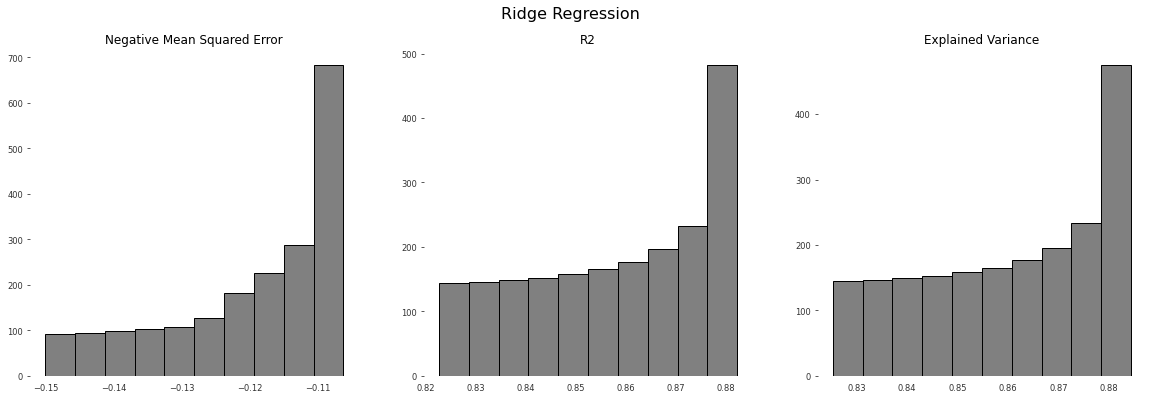

In [37]:
ridge_regressor.cv_results_.keys()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

fig.suptitle("Ridge Regression", fontsize="16")
axes[0].set_title("Negative Mean Squared Error")
axes[0].hist(ridge_regressor.cv_results_['mean_test_neg_mean_squared_error'], ec='black', color='grey')
axes[0].grid(False)

axes[1].set_title("R2")
axes[1].hist(ridge_regressor.cv_results_['mean_test_r2'], ec='black', color='grey')
axes[1].grid(False)

axes[2].set_title("Explained Variance")
axes[2].hist(ridge_regressor.cv_results_['mean_test_explained_variance'], ec='black', color='grey')
axes[2].grid(False)

### Lasso Regression

In [38]:
lasso_regression = Lasso()
hyper_parameters = {'alpha':[i/1000 for i in range(1, 1000)]}
lasso_regressor = GridSearchCV(lasso_regression, hyper_parameters, scoring=['neg_mean_squared_error', 'explained_variance', 'r2'], refit='explained_variance', cv=5)
lasso_regressor.fit(X_train,y_train)

print("Best value for lambda: ", lasso_regressor.best_params_)
print("Best score for cost function: ", lasso_regressor.best_score_)

Best value for lambda :  {'alpha': 0.009}
Best score for cost function:  0.8976483280158398


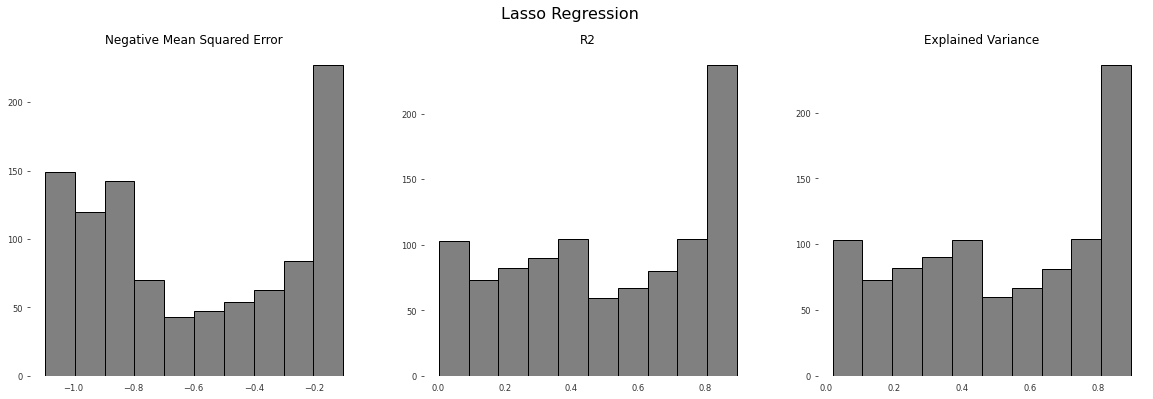

In [39]:
lasso_regressor.cv_results_.keys()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle("Lasso Regression", fontsize="16")
axes[0].set_title("Negative Mean Squared Error")
axes[0].hist(lasso_regressor.cv_results_['mean_test_neg_mean_squared_error'], ec='black', color='grey')
axes[0].grid(False)

axes[1].set_title("R2")
axes[1].hist(lasso_regressor.cv_results_['mean_test_r2'], ec='black', color='grey')
axes[1].grid(False)

axes[2].set_title("Explained Variance")
axes[2].hist(lasso_regressor.cv_results_['mean_test_explained_variance'], ec='black', color='grey')
axes[2].grid(False)

### SVM Regression

In [40]:
svr = svm.SVR()
hyper_parameters = {
                'C': [0.0001, 0.001, 0.01, 0.1], 
                'kernel': ['linear', 'rbf', 'sigmoid']} 

svr_cv = GridSearchCV(svr, hyper_parameters, scoring=['neg_mean_squared_error', 'explained_variance', 'r2'], refit='explained_variance', cv=5)
svr_cv.fit(X_train,y_train)

print("Best value for lambda : ", svr_cv.best_params_)
print("Best score for cost function: ", svr_cv.best_score_)

Best value for lambda :  {'C': 0.01, 'kernel': 'linear'}
Best score for cost function:  0.8968103682713586


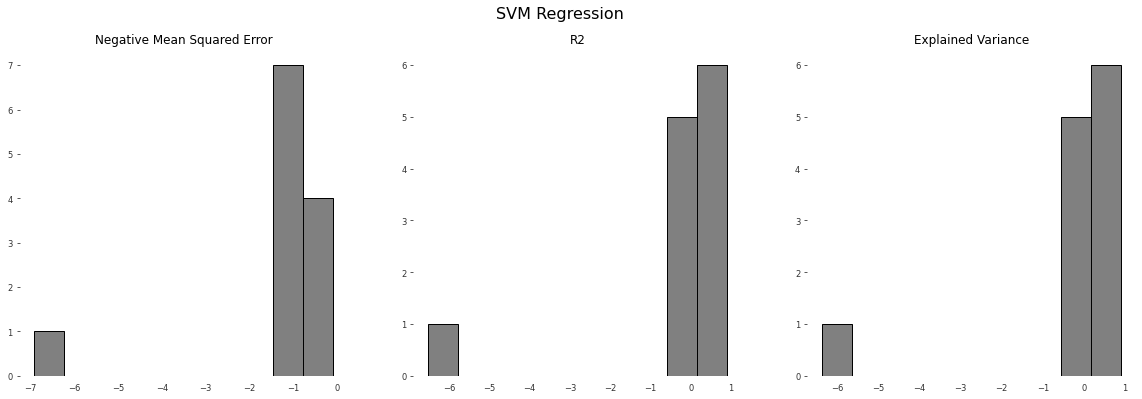

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle("SVM Regression", fontsize="16")
axes[0].set_title("Negative Mean Squared Error")
axes[0].hist(svr_cv.cv_results_['mean_test_neg_mean_squared_error'], ec='black', color='grey')
axes[0].grid(False)

axes[1].set_title("R2")
axes[1].hist(svr_cv.cv_results_['mean_test_r2'], ec='black', color='grey')
axes[1].grid(False)

axes[2].set_title("Explained Variance")
axes[2].hist(svr_cv.cv_results_['mean_test_explained_variance'], ec='black', color='grey')
axes[2].grid(False)

### Gradient Boosting

In [42]:
gbr = GradientBoostingRegressor()
hyper_parameters = {
                'max_depth': [1, 2, 3], 
                'learning_rate': [0.01, 0.1],
                'n_estimators': [10, 100, 1000]} 

gbr_cv = GridSearchCV(gbr, hyper_parameters, scoring=['neg_mean_squared_error', 'explained_variance', 'r2'], refit='explained_variance', cv=5)
gbr_cv.fit(X_train,y_train)

print("Best value for lambda : ", gbr_cv.best_params_)
print("Best score for cost function: ", gbr_cv.best_score_)

Best value for lambda :  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
Best score for cost function:  0.8844040746341102


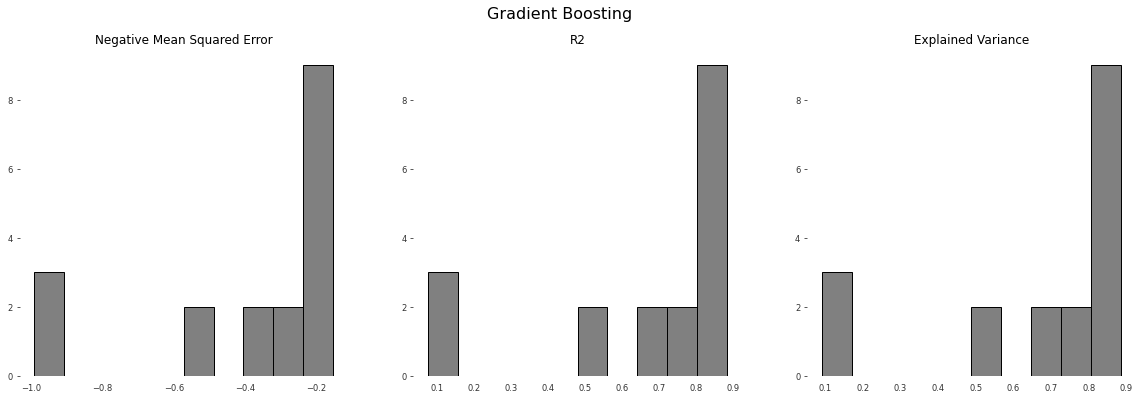

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle("Gradient Boosting", fontsize="16")
axes[0].set_title("Negative Mean Squared Error")
axes[0].hist(gbr_cv.cv_results_['mean_test_neg_mean_squared_error'], ec='black', color='grey')
axes[0].grid(False)

axes[1].set_title("R2")
axes[1].hist(gbr_cv.cv_results_['mean_test_r2'], ec='black', color='grey')
axes[1].grid(False)

axes[2].set_title("Explained Variance")
axes[2].hist(gbr_cv.cv_results_['mean_test_explained_variance'], ec='black', color='grey')
axes[2].grid(False)

### Comparison

In [44]:
models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(alpha = 0.009),
         'Ridge_alpha27.5': linear_model.Ridge(alpha = 27.5),
         'Ridge_defaultalpha': linear_model.Ridge(alpha=1),
         'SVM Regressor': svm.SVR(kernel='linear', C=1, gamma='scale'),
         'Gradient Boosting': GradientBoostingRegressor(max_depth=1, learning_rate=0.1, n_estimators=100)
         }

In [45]:
def test(models, X_train, y_train, X_test, y_test, iterations = 100):
    """
    Generates scores for a dictionary of metrics for each of the specified models for both the training
    and testing dataset, running many iterations to average performance

    Inputs
    -------
    models: [sklearn models]
        the models being benchmarked
    X_train: pd.DataFrame()
        training predictors
    y_train: pd.DataFrame()
        training outcomes
    X_test: pd.DataFrame()
        test predictors
    y_test: pd.DataFrame()
        test outcomes
    iterations: int
        number of iterations per model per score
    
    Outputs
    --------
    results_df: pd.DataFrame()
        dataframe summarising results for each specified model and score
    """

    scores = {'r2': metrics.r2_score, 'explained_variance': metrics.explained_variance_score}
    
    results = {i: {k1: [] for k1, k2 in scores.items()} for i in models}
    
    for i in models:
        r2_train = []
        r2_test = []
        for k1, k2 in scores.items():
            for j in range(iterations):

                r2_test.append(k2(y_test, models[i].fit(X_train, y_train).predict(X_test)))

                r2_train.append(k2(y_train, models[i].fit(X_train, y_train).predict(X_train)))

            results[i][k1] = [np.mean(r2_train), np.mean(r2_test)]

    results_df = pd.DataFrame.from_dict({(i,j): results[i][j] for i in results.keys() for j in results[i].keys()})

    results_df['type'] = ['train', 'test']
    results_df.set_index('type', inplace=True)
    return results_df

In [46]:
print('2019:')
display(test(models, X_train, y_train, X_test_2019, y_test_2019))

print('2020:')
display(test(models, X_train, y_train, X_test_2020, y_test_2020))

2019:


OLS                        Lasso                     \
             r2 explained_variance        r2 explained_variance   
type                                                              
train  0.921987           0.921987  0.920259           0.920259   
test   0.917897           0.917954  0.913223           0.913314   

      Ridge_alpha27.5                    Ridge_defaultalpha  \
                   r2 explained_variance                 r2   
type                                                          
train        0.920782           0.920782           0.921982   
test         0.913942           0.914016           0.917706   

                         SVM Regressor                    Gradient Boosting  \
      explained_variance            r2 explained_variance                r2   
type                                                                          
train           0.921982      0.919328           0.919330          0.960017   
test            0.917764      0.913578           0.913647          0.936752   

                          
      explained_variance  
type                      
train           0.960017  
test            0.936872

2020:


OLS                        Lasso                     \
             r2 explained_variance        r2 explained_variance   
type                                                              
train  0.921987           0.921987  0.920259           0.920259   
test   0.630770           0.644894  0.437257           0.460929   

      Ridge_alpha27.5                    Ridge_defaultalpha  \
                   r2 explained_variance                 r2   
type                                                          
train        0.920782           0.920782           0.921982   
test         0.383308           0.408226           0.616359   

                         SVM Regressor                    Gradient Boosting  \
      explained_variance            r2 explained_variance                r2   
type                                                                          
train           0.921982      0.919328           0.919330          0.960017   
test            0.631133      0.208206           0.239228          0.108156   

                          
      explained_variance  
type                      
train           0.960017  
test            0.150745

## Generating Optimised Regressions for 2019 & 2020

In [47]:
def generate_metrics(y_test, y_pred, year):
    """
    Generates a set of scores for a variety of metrics for predicted and actual test data for a given year

    Inputs
    -------
    y_test: np.array
        validation data
    y_pred: np.array
        predicted data
    year: str
        the year for which we're generating metrics
    
    Outputs
    -------
    df_metrics: pd.DataFrame()
        dataframe summarising all generated metrics
    """
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    r2=metrics.r2_score(y_test, y_pred)

    df_metrics = pd.DataFrame(zip(
    ["Year", "Explained Variance", "R2", "MAE", "MSE", "RMSE"],
    [year, explained_variance, r2, mean_absolute_error, mse, np.sqrt(mse)]
    ))
    return df_metrics

def generate_linear_regression(X_train, y_train, X_test, y_test, summary=True):
    """
    Runs linear regression on the specified datasets

    Inputs
    -------
    X_train: pd.DataFrame()
        training predictors
    y_train: pd.DataFrame()
        training outcomes
    X_test: pd.DataFrame()
        test predictors
    y_test: pd.DataFrame()
        test outcomes
    summary: bool
        whether to generate a full summary or just return the predicted outcome values
    
    Outputs
    --------
    df_coef: pd.DataFrame()
        dataframe of coefficients for the regression
    metrics_df: pd.DataFrame()
        dataframe of scoring metrics for the regression
    y_pred_df: pd.DataFrame()
        dataframe of predicted data 
    """
    linear = LinearRegression()
    linear.fit(X_train, y_train)

    y_pred = linear.predict(X_test)

    y_pred_df = pd.DataFrame(y_pred, columns=["outcome"])

    y_pred_df.loc[:, 'year'] = list(y_test['year'])
    
    metrics_dfs = []

    if summary:
        df_coef = pd.DataFrame(zip(X_test.columns, linear.coef_))

        for year in sorted(list(set(y_test['year']))):
            metrics_dfs.append(generate_metrics(y_test.loc[y_test['year'] == year, 'outcome'], y_pred_df.loc[y_pred_df['year'] == year, 'outcome'], year))

    
        return df_coef, metrics_dfs, y_pred_df
    return y_pred_df

def generate_ridge_regression(X_train, y_train, X_test, y_test, summary=True):
    """
    Runs ridge regression on the specified datasets
    
    Inputs
    -------
    X_train: pd.DataFrame()
        training predictors
    y_train: pd.DataFrame()
        training outcomes
    X_test: pd.DataFrame()
        test predictors
    y_test: pd.DataFrame()
        test outcomes
    summary: bool
        whether to generate a full summary or just return the predicted outcome values
    
    Outputs
    --------
    df_coef: pd.DataFrame()
        dataframe of coefficients for the regression
    metrics_df: pd.DataFrame()
        dataframe of scoring metrics for the regression
    y_pred_df: pd.DataFrame()
        dataframe of predicted data 
    """
    ridge = Ridge()
    ridge.fit(X_train, y_train)

    y_pred = ridge.predict(X_test)

    y_pred_df = pd.DataFrame(y_pred, columns=["outcome"])

    y_pred_df.loc[:, 'year'] = list(y_test['year'])
    
    metrics_dfs = []

    if summary:
        df_coef = pd.DataFrame(zip(X_test.columns, ridge.coef_))

        for year in sorted(list(set(y_test['year']))):
            metrics_dfs.append(generate_metrics(y_test.loc[y_test['year'] == year, 'outcome'], y_pred_df.loc[y_pred_df['year'] == year, 'outcome'], year))

    
        return df_coef, metrics_dfs, y_pred_df
    return y_pred_df


def generate_lasso_regression(X_train, y_train, X_test, y_test, summary=True):
    """
    Runs lasso regression on the specified datasets
    
    Inputs
    -------
    X_train: pd.DataFrame()
        training predictors
    y_train: pd.DataFrame()
        training outcomes
    X_test: pd.DataFrame()
        test predictors
    y_test: pd.DataFrame()
        test outcomes
    summary: bool
        whether to generate a full summary or just return the predicted outcome values
    
    Outputs
    --------
    df_coef: pd.DataFrame()
        dataframe of coefficients for the regression
    metrics_df: pd.DataFrame()
        dataframe of scoring metrics for the regression
    y_pred_df: pd.DataFrame()
        dataframe of predicted data 
    """
    lasso = Lasso(alpha=0.05)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)

    y_pred_df = pd.DataFrame(y_pred, columns={"outcome"})

    y_pred_df.loc[:, 'year'] = list(y_test['year'])
    
    metrics_dfs = []

    if summary:
        df_coef = pd.DataFrame(zip(X_test.columns, lasso.coef_))

        for year in sorted(list(set(y_test['year']))):
            metrics_dfs.append(generate_metrics(y_test.loc[y_test['year'] == year, 'outcome'], y_pred_df.loc[y_pred_df['year'] == year, 'outcome'], year))

    
        return df_coef, metrics_dfs, y_pred_df
    return y_pred_df

In [48]:
df_coef, metrics_dfs, y_pred_df = generate_linear_regression(X_train, y_train, X_test, y_test, summary=True)

display(df_coef)
for df in metrics_dfs:
    display(HTML(df.to_html()))

df_coef, metrics_dfs, y_pred_df = generate_ridge_regression(X_train, y_train, X_test, y_test, summary=True)

display(df_coef)
for df in metrics_dfs:
    display(HTML(df.to_html()))

df_coef, metrics_dfs, y_pred_df = generate_lasso_regression(X_train, y_train, X_test, y_test, summary=True)

display(df_coef)
for df in metrics_dfs:
    display(HTML(df.to_html()))

,0,1
0,health,-0.046473
1,smokers,0.065976
2,obesity,0.006596
3,drinking,0.026262
4,pollution,0.005720
5,sep_deaths,0.752933
6,pn_deaths,-0.222698
7,hyp_deaths,0.534563


,0,1
0,Year,2019
1,Explained Variance,0.918012
2,R2,0.917897
3,MAE,0.127831
4,MSE,0.100355
5,RMSE,0.316789


,0,1
0,Year,2020
1,Explained Variance,0.659018
2,R2,0.63077
3,MAE,0.165615
4,MSE,0.243687
5,RMSE,0.493647


,0,1
0,health,-0.045787
1,smokers,0.065430
2,obesity,0.006394
3,drinking,0.026451
4,pollution,0.006202
5,sep_deaths,0.743480
6,pn_deaths,-0.204808
7,hyp_deaths,0.531745


,0,1
0,Year,2019
1,Explained Variance,0.917823
2,R2,0.917706
3,MAE,0.127845
4,MSE,0.100589
5,RMSE,0.317157


,0,1
0,Year,2020
1,Explained Variance,0.645907
2,R2,0.616359
3,MAE,0.16752
4,MSE,0.253198
5,RMSE,0.503188


,0,1
0,health,-0.00000
1,smokers,0.00000
2,obesity,-0.00000
3,drinking,0.00000
4,pollution,0.00000
5,sep_deaths,0.64522
6,pn_deaths,0.00000
7,hyp_deaths,0.42311


,0,1
0,Year,2019
1,Explained Variance,0.904628
2,R2,0.904421
3,MAE,0.135227
4,MSE,0.116827
5,RMSE,0.341799


,0,1
0,Year,2020
1,Explained Variance,0.580181
2,R2,0.535385
3,MAE,0.185753
4,MSE,0.306639
5,RMSE,0.55375


In [49]:
# incorporating the results of the best model into the dataframe
y_pred_df = generate_ridge_regression(X_train, y_train, X_predict, y_predict, summary=False)

assert list(s_df[s_df['year'].isin(['2021', '2022'])]['year']) == list(y_pred_df['year'])
s_df.loc[s_df['year'].isin(['2021', '2022']), 'outcome'] = list(y_pred_df['outcome'])

In [50]:
s_df.isna().sum()

population    0
health        0
smokers       0
obesity       0
drinking      0
pollution     0
sep_deaths    0
pn_deaths     0
hyp_deaths    0
outcome       0
fips          0
state_fips    0
year          0
dtype: int64

## De-Standardising Regression

In [51]:
# inverse transforming the dataframe to cover actual values for predictors and outcome

float_df = s_df.select_dtypes('float')
other_df = s_df.select_dtypes(exclude='float')

rev_df = pd.DataFrame(standardised_scaler.inverse_transform(float_df), columns=float_df.columns, index=float_df.index)

assert(len(other_df.columns) == 3)

rev_df['fips'] = other_df['fips']
rev_df['state_fips'] = other_df['state_fips']
rev_df['year'] = other_df['year']

In [52]:
rev_df

,population,health,smokers,obesity,drinking,pollution,sep_deaths,pn_deaths,hyp_deaths,outcome,fips,state_fips,year
69,87687.0,12.0,16.0,27.0,23.300000,6.400000,121.000000,80.000000,196.0,382.000000,02020,02,2016
70,4426.0,23.9,34.3,31.6,20.600000,6.907259,20.346963,15.000000,13.0,16.000000,02050,02,2016
74,29675.0,11.0,16.2,28.6,23.000000,13.900000,20.000000,12.000000,66.0,37.000000,02090,02,2016
76,9083.0,9.9,17.1,27.0,23.000000,6.500000,10.000000,30.767481,18.0,18.000000,02110,02,2016
77,13503.0,12.5,19.5,28.0,23.700000,21.072913,19.000000,13.000000,50.0,73.000000,02122,02,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22300,28236.0,16.3,17.0,33.5,17.632523,5.400000,21.000000,44.000000,78.0,60.001083,56037,56,2022
22301,17782.0,11.6,11.3,22.2,19.368937,5.200000,21.448905,29.170510,12.0,14.996076,56039,56,2022
22302,13093.0,17.2,18.8,29.8,18.187334,6.900000,11.000000,13.000000,41.0,52.146543,56041,56,2022
22303,5515.0,17.3,17.6,28.9,19.070077,5.200000,6.652273,12.000000,21.0,28.940692,56043,56,2022


# Forecasting

In [53]:
f_df = rev_df.copy(deep=True)

In [54]:
f_df.isna().sum()

population    0
health        0
smokers       0
obesity       0
drinking      0
pollution     0
sep_deaths    0
pn_deaths     0
hyp_deaths    0
outcome       0
fips          0
state_fips    0
year          0
dtype: int64

In [55]:
f_df

,population,health,smokers,obesity,drinking,pollution,sep_deaths,pn_deaths,hyp_deaths,outcome,fips,state_fips,year
69,87687.0,12.0,16.0,27.0,23.300000,6.400000,121.000000,80.000000,196.0,382.000000,02020,02,2016
70,4426.0,23.9,34.3,31.6,20.600000,6.907259,20.346963,15.000000,13.0,16.000000,02050,02,2016
74,29675.0,11.0,16.2,28.6,23.000000,13.900000,20.000000,12.000000,66.0,37.000000,02090,02,2016
76,9083.0,9.9,17.1,27.0,23.000000,6.500000,10.000000,30.767481,18.0,18.000000,02110,02,2016
77,13503.0,12.5,19.5,28.0,23.700000,21.072913,19.000000,13.000000,50.0,73.000000,02122,02,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22300,28236.0,16.3,17.0,33.5,17.632523,5.400000,21.000000,44.000000,78.0,60.001083,56037,56,2022
22301,17782.0,11.6,11.3,22.2,19.368937,5.200000,21.448905,29.170510,12.0,14.996076,56039,56,2022
22302,13093.0,17.2,18.8,29.8,18.187334,6.900000,11.000000,13.000000,41.0,52.146543,56041,56,2022
22303,5515.0,17.3,17.6,28.9,19.070077,5.200000,6.652273,12.000000,21.0,28.940692,56043,56,2022


In [56]:
def remove_incomplete_series(input_df):
    """
    Removes all rows for the dataframe for which there aren't outputs for all years for the associated county

    Inputs
    ------
    input_df: pd.DataFrame()
        df to be manipulated
    
    Outputs
    -------
    df: pd.DataFrame()
        df without incomplete rows
    """
    df = input_df.copy(deep=True)
    print(len(df))
    incomplete = df.groupby(['fips'])['year'].aggregate(lambda x: tuple(x)).apply(sorted).reset_index()
    incomplete['year'] = incomplete['year'].map(tuple)
    incomplete = incomplete[incomplete['year'] != ("2016", "2017", "2018", "2019", "2020", "2021", "2022")]
    df = df[~df['fips'].isin(incomplete['fips'])]
    print(len(df))
    return df

f_df = remove_incomplete_series(f_df)

16510
14308


In [57]:
# generating time-series from the remaining data

f_df['year'] = pd.to_datetime(f_df['year'])

float64_cols = list(df.select_dtypes(include='float64'))
df[float64_cols] = df[float64_cols].astype('float32')

ts = TimeSeries.from_group_dataframe(f_df, 
                                     group_cols=['fips'], 
                                     time_col='year', 
                                     value_cols="outcome")

ts_cov = TimeSeries.from_group_dataframe(f_df, 
                                     group_cols=['fips'], 
                                     time_col='year', 
                                     value_cols=['health', 'smokers', 'obesity', 'drinking', 'pollution', 'sep_deaths', 'pn_deaths', 'hyp_deaths'])

In [58]:
split_ts = [series.split_before(pd.Timestamp("20200202")) for series in ts]
split_ts_cov = [series.split_before(pd.Timestamp("20200202")) for series in ts_cov]
train, validation = [x[0] for x in split_ts], [x[1] for x in split_ts]
train_cov, validation_cov = [x[0] for x in split_ts_cov], [x[1] for x in split_ts_cov]

In [59]:
model_cov = NHiTSModel(input_chunk_length=3, output_chunk_length=2, n_epochs=200, batch_size=256, pl_trainer_kwargs={"accelerator": "cpu"})

In [60]:
model_cov.fit(train, past_covariates=train_cov)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 900 K 
---------------------------------------------------
886 K     Trainable params
13.9 K    Non-trainable params
900 K     Total params
3.601     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 23.38it/s, train_loss=2.28e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 23.07it/s, train_loss=2.28e+3]


NHiTSModel(num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=3, output_chunk_length=2, n_epochs=200, batch_size=256, pl_trainer_kwargs={'accelerator': 'cpu'})

In [61]:
val_cov = model_cov.predict(n=2, series=train, past_covariates=train_cov)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]


In [62]:
print("Coefficient of Variation:", np.mean(coefficient_of_variation(ts, val_cov)), np.std(coefficient_of_variation(ts, val_cov)))
print("MAE:", np.mean(mae(ts, val_cov)), np.std(mae(ts, val_cov)))
print("MAPE:", np.mean(mape(ts, val_cov)), np.std(mape(ts, val_cov)))

Coefficient of Variation: 77.30997169252505 211.16893290458935
MAE: 107.57182915409987 246.23666151067508
MAPE: 65.2104654120118 169.965419675801


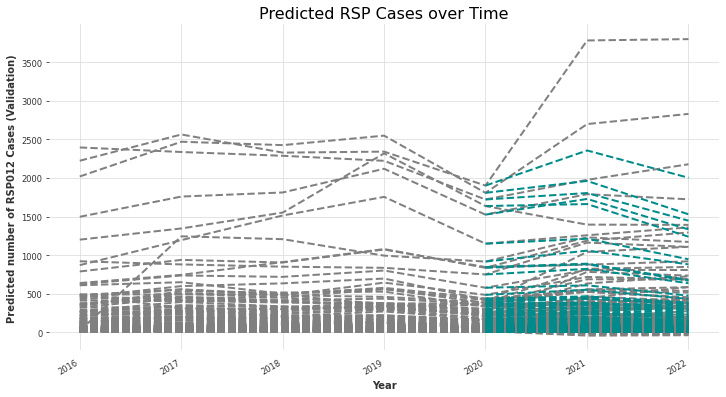

In [63]:
k_val = 200
indices = random.sample(range(len(ts)), k=k_val)

line_pred_val_cov = [train[idx].concatenate(val_cov[idx]).split_after(pd.Timestamp("20190202"))[1] for idx in range(len(val_cov)-1)]

plt.figure(figsize=(12, 6))
for series in [ts[i] for i in indices]:
    series.plot(color='grey', alpha=0.1, linestyle='--')
for val_series in [line_pred_val_cov[i] for i in indices]:
    val_series.plot(color='darkcyan', alpha=0.1, linestyle='--')
plt.legend().remove()
plt.title("Predicted RSP Cases over Time", fontsize='16')
plt.xlabel("Year")
plt.ylabel("Predicted number of RSP012 Cases (Validation)")
plt.show()


In [64]:
pred_cov = model_cov.predict(n=1, series=ts, past_covariates=ts_cov)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]


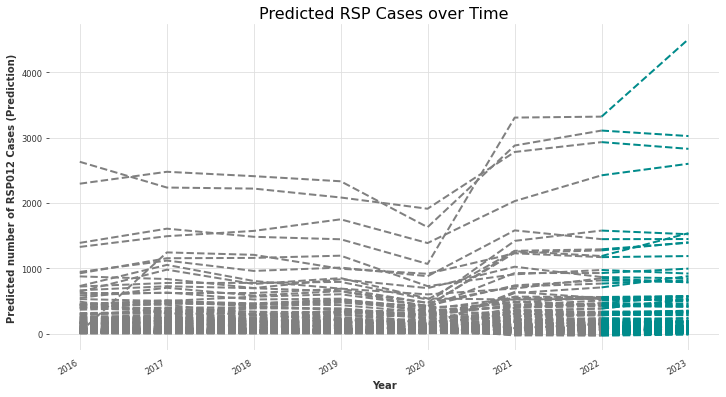

In [65]:
k_val = 200

line_pred_cov = [ts[idx].concatenate(pred_cov[idx]).split_after(pd.Timestamp("20210202"))[1] for idx in range(len(pred_cov)-1)]

indices = random.sample(range(len(line_pred_cov)), k=k_val)

plt.figure(figsize=(12, 6))
for series in [ts[i] for i in indices]:
    series.plot(color='grey', alpha=0.1, linestyle='--')
for val_series in [line_pred_cov[i] for i in indices]:
    val_series.plot(color='darkcyan', alpha=0.1, linestyle='--')
plt.legend().remove()
plt.title("Predicted RSP Cases over Time", fontsize='16')
plt.xlabel("Year")
plt.ylabel("Predicted number of RSP012 Cases (Prediction)")
plt.show()


In [66]:
forecast_df = pd.DataFrame([(series.static_covariates['fips'][0], series.values()[0][0]) for series in pred_cov], columns=['fips', 'outcome'])
forecast_df['year'] = '2023'

In [67]:
f_df = pd.concat([f_df, forecast_df], axis=0)

# Visualisation

## Preparation

In [68]:
v_df = f_df.copy(deep=True)

In [69]:
v_df.head()

,population,health,smokers,obesity,drinking,pollution,sep_deaths,pn_deaths,hyp_deaths,outcome,fips,state_fips,year
69,87687.0,12.0,16.0,27.0,23.3,6.400000,121.000000,80.000000,196.0,382.0,02020,02,2016-01-01 00:00:00
70,4426.0,23.9,34.3,31.6,20.6,6.907259,20.346963,15.000000,13.0,16.0,02050,02,2016-01-01 00:00:00
74,29675.0,11.0,16.2,28.6,23.0,13.900000,20.000000,12.000000,66.0,37.0,02090,02,2016-01-01 00:00:00
76,9083.0,9.9,17.1,27.0,23.0,6.500000,10.000000,30.767481,18.0,18.0,02110,02,2016-01-01 00:00:00
77,13503.0,12.5,19.5,28.0,23.7,21.072913,19.000000,13.000000,50.0,73.0,02122,02,2016-01-01 00:00:00


In [70]:
req = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
context = ssl._create_unverified_context()
with urllib.request.urlopen(req,context=context) as response: 
    counties = json.load(response)

In [71]:
# append geojson data describing county heatmap positions to every row in the dataframe
for obj in counties['features']:
    if(not len(v_df.index[v_df['fips'] == obj['id']]) == 0):
        geojson = {
            "type": obj['type'], 
            "geometry": {
                "type": obj['geometry']['type'], 
                'coordinates': obj['geometry']['coordinates']}, 
            "properties": {
                "name": obj['properties']['NAME'],
                "GEO_ID": obj['properties']['GEO_ID'],
                },
            "id": obj['id']
        }
        v_df.loc[v_df.index[v_df['fips'] == obj['id']], 'geojson'] = json.dumps(geojson)
        v_df.loc[v_df.index[v_df['fips'] == obj['id']], 'county_name'] = obj['properties']['NAME']

In [72]:
state_mapping = {
  "10": "Delaware",
  "11": "District of Columbia",
  "12": "Florida",
  "13": "Georgia",
  "15": "Hawaii",
  "16": "Idaho",
  "17": "Illinois",
  "18": "Indiana",
  "19": "Iowa",
  "20": "Kansas",
  "21": "Kentucky",
  "22": "Louisiana",
  "23": "Maine",
  "24": "Maryland",
  "25": "Massachusetts",
  "26": "Michigan",
  "27": "Minnesota",
  "28": "Mississippi",
  "29": "Missouri",
  "30": "Montana",
  "31": "Nebraska",
  "32": "Nevada",
  "33": "New Hampshire",
  "34": "New Jersey",
  "35": "New Mexico",
  "36": "New York",
  "37": "North Carolina",
  "38": "North Dakota",
  "39": "Ohio",
  "40": "Oklahoma",
  "41": "Oregon",
  "42": "Pennsylvania",
  "44": "Rhode Island",
  "45": "South Carolina",
  "46": "South Dakota",
  "47": "Tennessee",
  "48": "Texas",
  "49": "Utah",
  "50": "Vermont",
  "51": "Virginia",
  "53": "Washington",
  "54": "West Virginia",
  "55": "Wisconsin",
  "56": "Wyoming",
  "01": "Alabama",
  "02": "Alaska",
  "04": "Arizona",
  "05": "Arkansas",
  "06": "California",
  "08": "Colorado",
  "09": "Connecticut",
  "72": "Puerto Rico",
  "66": "Guam",
  "78": "Virgin Islands",
  "60": "American Samoa"
  }

inverse_state_mapping = dict(map(reversed, state_mapping.items()))

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

state_abbrev_to_fips = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}


In [73]:
# standardise state fips
v_df['state_fips'] = v_df['fips'].str[:2]
v_df['state_name'] = v_df['state_fips'].apply(lambda x: state_mapping[x])
v_df['state_abbr'] = v_df['state_name'].apply(lambda x: us_state_to_abbrev[x])
v_df['year'] = v_df['year'].apply(str).str[:4]

# add hospitals to dataframe
hospitals_df = geopandas.read_file("gen1e_project/us_hospitals/v10/ghospitl.gdb")
hospitals_df['x'] = hospitals_df.geometry.x
hospitals_df['y'] = hospitals_df.geometry.y
hospitals_df = hospitals_df.rename(columns={"STCTYFIPS": "fips"})
hospitals_df.reset_index(inplace=True)
grouped_hospitals = hospitals_df.groupby('fips').aggregate(tuple)["NAME"].reset_index()

for idx, row in grouped_hospitals.iterrows():
    v_df.loc[v_df['fips'] == row['fips'], 'hospitals'] = json.dumps(row['NAME'])

hospitals_df = hospitals_df.merge(v_df[['fips', 'county_name', 'state_name']], on='fips', how='inner')


## Generation

In [74]:
def filter_df(input_df,  year=None, state=None):
    """
    Filters the input dataframe by specified year and state for subset views of the heatmap

    Inputs
    -------
    input_df: pd.DataFrame()
        the dataframe to be subsetted
    year: str
        the year by which to subset the dataframe
    state: str
        the name of the state by which to subset the dataframe
    
    Outputs
    -------
    df: pd.DataFrame()
        the subsetted dataframe
    """
    df = input_df.copy(deep=True)

    if year in list(set(df['year'])):
        input_year = [str(year)] if year else list(set(df['year']))
        input_state = [str(state)] if state else list(set(df['state_name']))

        df = df.loc[(df['year'].isin(input_year)) & (df['state_name'].isin(input_state)), :]

        return df
        
    else:
        grouped_df = v_df.groupby('fips').agg({
            "population": np.mean, "health": np.mean, "smokers": np.mean, "obesity": np.mean, "drinking": np.mean, "pollution": np.mean, "sep_deaths": np.mean, "pn_deaths": np.mean, "hyp_deaths": np.mean, "outcome": np.mean,
            "fips": "first", "state_fips": "first", 'year': "first", 'geojson': "first", 'county_name': "first", 'state_name': "first", 'state_abbr': "first", 'hospitals': "first"
        }).sort_values(by='outcome', ascending=False)
        grouped_df.drop(labels='fips', axis=1, inplace=True)
        grouped_df.reset_index(inplace=True)

        return grouped_df

In [75]:
def normalise_columns(input_df, columns, selection_year):
    """
    Creates a normalised ([0-1]) aggregate numpy aggregate combinerd by adding the normalised data from each specified column and then normalising again

    Inputs
    ------
    input_df: pd.DataFrame()
        the dataframe from which column data is read
    columns: [str]
        the list of column names to normalise, all of which must be in input_df
    selection_year: str
        the year by which input_df is subsetted
    
    Output
    -------
    acc: np.array
        array of normalised aggregate values between 0 and 1

    """
    df = input_df.copy(deep=True)
    df = df[df['year'] == str(selection_year)] if selection_year not in ["All", None] else df.groupby('fips').mean()

    if len(columns) == 1:
        return df[columns[0]]
    else:
        acc = np.zeros(len(df))
        for column in columns:
            series = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            acc += np.array(series)
        
        acc = (acc - min(acc)) / ( max(acc) - min(acc))
        
        return acc

In [76]:
v_df.head()

,population,health,smokers,obesity,drinking,pollution,sep_deaths,pn_deaths,hyp_deaths,outcome,fips,state_fips,year,geojson,county_name,state_name,state_abbr,hospitals
69,87687.0,12.0,16.0,27.0,23.3,6.400000,121.000000,80.000000,196.0,382.0,02020,02,2016,"{""type"": ""Feature"", ""geometry"": {""type"": ""Poly...",Monroe,Alaska,AK,"[""Providence Alaska Medical Center"", ""Alaska P..."
70,4426.0,23.9,34.3,31.6,20.6,6.907259,20.346963,15.000000,13.0,16.0,02050,02,2016,"{""type"": ""Feature"", ""geometry"": {""type"": ""Poly...",Montgomery,Alaska,AK,"[""Yukon Kuskokwim Health Clara Morgan Subregio..."
74,29675.0,11.0,16.2,28.6,23.0,13.900000,20.000000,12.000000,66.0,37.0,02090,02,2016,"{""type"": ""Feature"", ""geometry"": {""type"": ""Poly...",Perry,Alaska,AK,"[""Fairbanks Memorial Hospital"", ""Bassett Army ..."
76,9083.0,9.9,17.1,27.0,23.0,6.500000,10.000000,30.767481,18.0,18.0,02110,02,2016,"{""type"": ""Feature"", ""geometry"": {""type"": ""Poly...",Pike,Alaska,AK,"[""Bartlett Regional Hospital"", ""Family Practic..."
77,13503.0,12.5,19.5,28.0,23.7,21.072913,19.000000,13.000000,50.0,73.0,02122,02,2016,"{""type"": ""Feature"", ""geometry"": {""type"": ""Poly...",Poinsett,Alaska,AK,"[""Ninilchik Traditional Council Ninilchik Comm..."


In [77]:
def print_top_counties(df, year, state=None, hospitals=False):
    """
    Prints the counties with the highest outcome (RSP012) values for the given year and state. Optionally prints all hospitals within those counties.

    Inputs
    ------
    df: pd.DataFrame()
        the dataframe from which to print data
    year: str
        the year by which the dataframe is subsetted
    state: str
        the name of the state by which the dataframe is subsetted
    hospitals: bool
        whether to print the names all of hospitals located within each relevant county

    Outputs: None
    """
    class color:
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        END = '\033[0m'

        year = "2023"
    
    input_state = [state] if state else list(set(v_df['state_name']))
    
    if(year in set(df['year'])):
        print(color.BOLD + color.UNDERLINE + f"Top Counties for {year} {'(' + state + ')' if state else ''}" + color.END)
        for idx, row in df.loc[(df['year'] == year) & (df['state_name'].isin(input_state)), :].sort_values(by='outcome', ascending=False)[:10].iterrows():
            print(f"{color.BOLD} {color.DARKCYAN} [{row['fips']}] {row['county_name']}, {row['state_name']}: {color.END} {int(row['outcome'])} cases")

            if hospitals:
                for hospital in json.loads(row['hospitals']):
                    print(hospital + ', ', end='')
                print('\n')
    else:
        print(color.BOLD + color.UNDERLINE + f"Top Counties Averaged Across All Years {' (' + state + ')' if state else ''}" + color.END)

        grouped_df = v_df.groupby('fips').agg({
        "population": np.mean, "health": np.mean, "smokers": np.mean, "obesity": np.mean, "drinking": np.mean, "pollution": np.mean, "sep_deaths": np.mean, "pn_deaths": np.mean, "hyp_deaths": np.mean, "outcome": np.mean,
        "fips": "first", "state_fips": "first", 'year': "first", 'geojson': "first", 'county_name': "first", 'state_name': "first", 'state_abbr': "first", 'hospitals': "first"
            }).sort_values(by='outcome', ascending=False)
        grouped_df.drop(labels='fips', axis=1, inplace=True)
        grouped_df.reset_index(inplace=True)


        for idx, row in grouped_df.loc[grouped_df['state_name'].isin(input_state), :][:10].iterrows():
            print(f"{color.BOLD} {color.DARKCYAN} [{row['fips']}] {row['county_name']}, {row['state_name']}: {color.END} {int(row['outcome'])} cases")

        if hospitals:
            for idx, row in grouped_df[:10].iterrows():
                print(f"{color.BOLD} {color.CYAN} {row['county_name']}, {row['state_name']}: {color.END} {int(row['outcome'])} cases")
                for hospital in json.loads(row['hospitals']):
                    print(hospital + ', ', end='')
                print('\n')
    print("\n")

In [78]:
app = Dash(__name__)

app.layout = html.Div(
    children=[
        html.Div(
            children=[
                html.H4("ARDS in the United States", style={'font-size': "34px", 'font-family': "Helvetica Neue", "margin": '0px', 'padding': "0px", "color": "#4b5563"})
            ],
            style={
                'flex': 0.1,
                'flex-grow': 0,
                'width': "100%",
            }
        ),
        html.Div(
            children=[
            html.Div(
                [
                    dcc.Loading([
                        map_trigger := html.Div(),
                        map_graph := dcc.Graph(id="graph", style={'width': "100%", "height": "100%", "flex": 1}),
                        ],
                        parent_style={'height': '100%'},
                        type='circle',
                        style={'color': "#e7e7e7"},
                    ),
                ],
                style={'border': "1px solid #e7e7e7", "width": "90%", "height": "90%", 'flex': 1, 'box-shadow': "4px 4px -1px 11px #e7e7e7", "background-color": "white", 'display': 'flex', 'flex-direction': "column"}
            ),
            html.Div(
                [
                    html.H4('Controls', style={'font-size': "20px", 'font-family': "Helvetica Neue", "color": "#4b5563", "margin": '0px', 'padding': "0px"}),
                    
                    dcc.Dropdown(
                        [*list(sorted(list(set(v_df['year'].apply(str).str[:4]))))],
                        id="selection_year",
                        style={"width": "100%",  "margin-bottom": "5px", 'margin-top': "5px", 'font-family': "Helvetica Neue"},
                        value='2023'
                    ),

                    dcc.Dropdown(
                        ['None', *list(sorted(list(set(v_df['state_name']))))],
                        id="state_dropdown",
                        style={"width": "100%", "margin-bottom": "5px", 'margin-top': "5px", 'font-family': "Helvetica Neue"},
                        placeholder='Filter States'
                    ),

                    html.Div(
                        [
                            html.P("Select options to view (normalized when aggregated):", style={
                                'font-size': '16px',
                                'font-family': "Helvetica Neue",
                            }),
                            dcc.Checklist(
                                options=[
                                    {
                                        "label": html.Div(['RSP012 Cases'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "outcome",
                                    },
                                    {
                                        "label": html.Div(['Low to Moderate Health Levels'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "health",
                                    },
                                    {
                                        "label": html.Div(['County Population'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "population",
                                    },
                                                                        {
                                        "label": html.Div(['% Smokers'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "smokers",
                                    },
                                    {
                                        "label": html.Div(['% Obese'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "obesity",
                                    },
                                    {
                                        "label": html.Div(['Local Pollution Levels (avg. daily ppm)'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "pollution",
                                    },
                                    {
                                        "label": html.Div(['Annual Deaths from Septicemia'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "sep_deaths",
                                    },
                                    {
                                        "label": html.Div(['Annual Deaths from Pneumonia'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "pn_deaths",
                                    },
                                    {
                                        "label": html.Div(['Annual Deaths from Hypertension'], style={'color': '#4b5563', 'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "hyp_deaths",
                                    },



                                ], value=['outcome'],
                            labelStyle={"display": "flex", "align-items": "center", 'font-family': "Helvetica Neue", 'flex-direction': 'row'},
                            style={'display': 'flex', "gap": '5px', "flex-wrap":'wrap'},
                            id='metrics',
                            inline=True
                            ),
                        ], style={"display": 'flex', "flex-direction": "column"}),

                    html.Div(
                        [
                            html.P("Select overlays:", style={
                                'font-size': '16px',
                                'font-family': "Helvetica Neue",
                            }),
                            dcc.Checklist(
                                options=[
                                    {
                                        "label": html.Div(['Hospitals'], style={'font-size': 14, 'font-family': "Helvetica Neue", "letter-spacing": "-0.03em"}),
                                        "value": "hospitals",
                                    },
                                ], value=[],
                            labelStyle={"display": "flex", "align-items": "center", 'font-family': "Helvetica Neue", 'flex-direction': 'row'},
                            style={'display': 'flex'},
                            id='overlays',
                            inline=True
                            ),
                        ],
                        style={'display': 'flex', 'flex-direction': 'row'}
                    ),
                    html.Div(
                        [
                            
                        ],
                        style={'flex': 1, "width": '100%'}
                    )
                ],
                style={"flex": 0.7, "height": "100%", "display": "flex", "flex-direction": 'column', 'padding': "20px"}
                )
            
            ],
            style={
                'padding': "20px",
                'flex': 1,
                "width": "100%",
                'box-sizing': "border-box",
                "display": 'flex',
                'flex-direction': 'row',
                'justify-content': "center",
                "align-items": 'center',
                'gap': '0px'
            }
        )
    ],
    style={
        'background-color': "#eeeeee",
        "height": "100vh",
        "width": "100vw",
        'display': 'flex',
        "flex-direction": 'column',
        "border": "2px solid #e7e7e7",
        'padding': "20px",
        'margin': '0px !important',
    }
)

@app.callback(Output(map_trigger, 'children'), Input(map_graph, 'loading_state'))
def onLoading(state):
    return

@app.callback(
    Output("graph", "figure"), 
    Input("metrics", "value"),
    Input("overlays", "value"),
    Input("state_dropdown", "value"),
    Input("selection_year", "value"),
    )
def display_choropleth(metrics, overlays, state_dropdown, selection_year):

    print_top_counties(v_df, str(selection_year), state=None if state_dropdown in ['None', None] else state_dropdown)

    fig = go.Figure()

    
    fig.add_trace(go.Choropleth(
        locations=filter_df(v_df, year=selection_year, state=state_dropdown)['fips'],
        z=normalise_columns(v_df, metrics, selection_year),
        colorscale="Agsunset",
        zmax= None if metrics != ['outcome']  else 3000,
        zmin=0,
        # autocolorscale=True,
        hovertemplate=[f"<em>{row['county_name']}, {row['state_name']}</em> <br> <i>RSP012 Discharges: {int(row['outcome']) if not math.isnan(row['outcome']) else None}</i><br> County Population: {int(row['population']) if not math.isnan(row['population']) else None} people <br> Low to Moderate Health: {round(row['health'], 1) if not math.isnan(row['health']) else None} % <br> Smokers: {round(row['smokers'], 1) if not math.isnan(row['smokers']) else None}% <br>Obese: {round(row['obesity'], 1) if not math.isnan(row['obesity']) else None}% <br> Pollution (ppm): {round(row['pollution'], 1) if not math.isnan(row['pollution']) else None} <br> Deaths from Sepsis: {int(row['sep_deaths']) if not math.isnan(row['sep_deaths']) else None} <br> Death from Hypertension: {int(row['hyp_deaths']) if not math.isnan(row['hyp_deaths']) else None} <br> Deaths from Pneumonia: {int(row['pn_deaths']) if not math.isnan(row['pn_deaths']) else None} <br>  Normalised Score: {'%{z}'} <extra>{row['state_abbr']}</extra>" for index, row in filter_df(v_df, year=selection_year, state=state_dropdown).iterrows()],
        geojson={"type": "FeatureCollection", "features": [json.loads(i) for i in v_df['geojson']]},
        # colorbar_title='Normalised Score [0-1]',
        colorbar=dict(orientation='h', thickness=10),
        marker_line_color='black',
        # showscale=False,
    ))

    fig.update_layout(
        margin={"r":0,"t":0,"l":0,"b":0},
        geo = dict(
            scope='usa',
            projection=go.layout.geo.Projection(type = 'albers usa'), 
            fitbounds='locations' if state_dropdown not in ["None", None] else False
            )
    )

    fig.add_trace(go.Scattergeo(      
        lon = hospitals_df[hospitals_df['fips'].str[:2] == inverse_state_mapping[state_dropdown]]['x'] if state_dropdown not in ["None", None] else hospitals_df['x'],
        lat = hospitals_df[hospitals_df['fips'].str[:2] == inverse_state_mapping[state_dropdown]]['y'] if state_dropdown not in ["None", None] else hospitals_df['y'],
        mode = 'markers',
        marker_color = "red",
        hovertemplate=[f"<em>{row['NAME']}</em> <br> County: {row['county_name']} <extra>{row['state_name']}</extra>" for idx, row in hospitals_df.iterrows()],
        # <extra>{df[df['fips'] == row['fips']]['county_name'][0]}</extra>
        visible = True if 'hospitals' in overlays else False,
            marker = dict(
                size = 4,
                opacity = 0.5,
                symbol = 'square',
            )
    ))

    return fig

app.server.run(port=8000, host='127.0.0.1', debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8000
Press CTRL+C to quit
127.0.0.1 - - [17/Jul/2023 12:04:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2023 12:04:09] "GET /_favicon.ico?v=2.11.1 HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2023 12:04:09] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2023 12:04:09] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2023 12:04:09] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [17/Jul/2023 12:04:09] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [17/Jul/2023 12:04:09] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -


Top Counties for 2023 
  [06037] Bradley, California:  16215 cases
  [48201] Harris, Texas:  7219 cases
  [17031] Cook, Illinois:  6904 cases
  [04013] Maricopa, Arizona:  5949 cases
  [12086] Miami-Dade, Florida:  4977 cases
  [06073] Franklin, California:  4924 cases
  [06059] Crawford, California:  4573 cases
  [40109] Oklahoma, Oklahoma:  4507 cases
  [32003] Clark, Nevada:  4502 cases
  [48029] Bexar, Texas:  4222 cases




127.0.0.1 - - [17/Jul/2023 12:04:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Jul/2023 12:04:17] "POST /_dash-update-component HTTP/1.1" 200 -


Top Counties for 2023 (California)
  [06037] Bradley, California:  16215 cases
  [06073] Franklin, California:  4924 cases
  [06059] Crawford, California:  4573 cases
  [06065] Dallas, California:  3964 cases
  [06071] San Bernardino, California:  3662 cases
  [06085] Santa Clara, California:  3277 cases
  [06067] Desha, California:  2828 cases
  [06001] Alameda, California:  2081 cases
  [06019] Fresno, California:  1974 cases
  [06111] Ventura, California:  1576 cases




127.0.0.1 - - [17/Jul/2023 12:04:28] "POST /_dash-update-component HTTP/1.1" 200 -
